## Look at Partition Performance Using ML techniques

In [18]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
%config Completer.use_jedi = False

**Extract the partitioned wave params**

In [20]:
offshore = pd.read_csv('../data/offshoreParams_partitioned.csv', index_col = 'time_a', parse_dates = True)

### Method 1: 12 hr extract
We will extract the first 12 hours from each model run and treat it as a single timeseries. <br>
For the purposes of keeping things simple we will use one of the offshore site locations.

We are hypothesising two things, one the model performs best in this time range. The second is that bias against observations is likely to be smallest.

In [21]:
#modgrps = offshore.groupby('ModelRun')

In [22]:
#allruns12hr = []
#for nm, group in modgrps:
#    allruns12hr.append(group[group['site'] == 359.0].iloc[:12])

In [23]:
#data12 = pd.concat(allruns12hr)

In [24]:
offshore.head(2)

,lat_a,lon_a,hs_a,hmax_a,tp_a,tm01_a,tm02_a,dpm_a,dm_a,dspr_a,...,tm01_sa_c,tm02_sa_c,dm_sa_c,dspr_sa_c,hs_sw_c,hmax_sw_c,tm01_sw_c,tm02_sw_c,dm_sw_c,dspr_sw_c
time_a,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,-28.67,153.87,1.592309,2.875773,7.419529,5.744221,5.287222,85.26342,107.688501,51.389665,...,5.071193,4.770557,122.806554,52.115608,0.787214,1.356680,9.645351,9.462669,106.446446,54.681822
2021-01-01 01:00:00,-28.67,153.87,1.616266,2.918713,7.597932,5.775996,5.293211,84.06771,105.568917,51.905817,...,5.047232,4.738713,123.729704,52.843299,0.814062,1.403259,9.636326,9.457174,103.201231,54.460662


In [25]:
data12 = offshore

In [26]:
data12 = data12.sort_index()

In [27]:
data12 = data12[~data12.index.duplicated(keep='first')]

#### Let's checkout a data

<AxesSubplot:xlabel='time_a'>

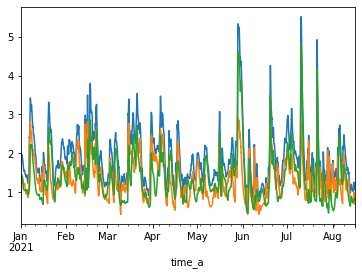

In [28]:
data12.hs_a.plot()
data12.hs_sa_a.plot()
data12.hs_sw_a.plot()

**Simplyfy:**
Use mean direction, remove fields we don't need and round data down to 2 decimal places. 
Why, becuase any more decimal places that this is superfluous information.

In [29]:
data12 = data12[['hs_a','tm02_a','tp_a','dpm_a','dm_a','hs_sa_a','tm02_sa_a','dm_sa_a','hs_sw_a','tm02_sw_a','dm_sw_a',
                'hs_b','tm02_b','tp_b','dpm_b','dm_b','hs_sa_b','tm02_sa_b','dm_sa_b','hs_sw_b','tm02_sw_b','dm_sw_b', 
                'hs_c','tm02_c','tp_c','dpm_c','dm_c','hs_sa_c','tm02_sa_c','dm_sa_c','hs_sw_c','tm02_sw_c','dm_sw_c']].round(2)
data12.head(2)

,hs_a,tm02_a,tp_a,dpm_a,dm_a,hs_sa_a,tm02_sa_a,dm_sa_a,hs_sw_a,tm02_sw_a,...,tm02_c,tp_c,dpm_c,dm_c,hs_sa_c,tm02_sa_c,dm_sa_c,hs_sw_c,tm02_sw_c,dm_sw_c
time_a,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1.59,5.29,7.42,85.26,107.69,1.40,4.82,109.34,0.82,9.31,...,5.18,6.58,127.64,123.03,1.45,4.77,122.81,0.79,9.46,106.45
2021-01-01 01:00:00,1.62,5.29,7.60,84.07,105.57,1.41,4.79,108.41,0.86,9.31,...,5.17,6.61,129.64,122.70,1.47,4.74,123.73,0.81,9.46,103.20


In [30]:
len(data12)

5461

### Observations
Bring in some observations for the same period this will be our labels (target parameters)

In [31]:
import sqlite3
import toolBOX

In [32]:
latestObs = pd.read_csv('../data/waveObs.csv', index_col = 0, parse_dates = True)

C:\Users\Leo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Filter to remove some bad obs**

In [33]:
latestObs = latestObs[latestObs['Hsig'] > 0.1]

In [34]:
Obs = latestObs[latestObs['Site'] == 'Tweed Heads Mk4']

In [35]:
Obs.index = pd.to_datetime(Obs.DateTime)

**Merge in obs from database of Obs**

In [36]:
moreObs = toolBOX.get_waveDB_xday_obs(dbpath = '../data/wave_obs.db', days = 900)

In [37]:
Obs = pd.concat([Obs, moreObs[moreObs['Site'] =='Tweed Heads Mk4'].loc[latestObs.index[-1]:]])

In [38]:
Obs = Obs[Obs.Hsig > 0.01]
Obs = Obs.drop_duplicates(keep = 'first')
Obs = Obs[~Obs.index.duplicated(keep = 'first')]
Obs = Obs.sort_index()

In [39]:
Obs = Obs[['Hsig','Hmax','Tp','Tz','Direction']]
Obs = Obs.resample('H').mean()
Obs = Obs.dropna()
Obs = Obs.round(2)

In [40]:
Obs.index = Obs.index - pd.Timedelta(hours = 10)

<AxesSubplot:xlabel='DateTime'>

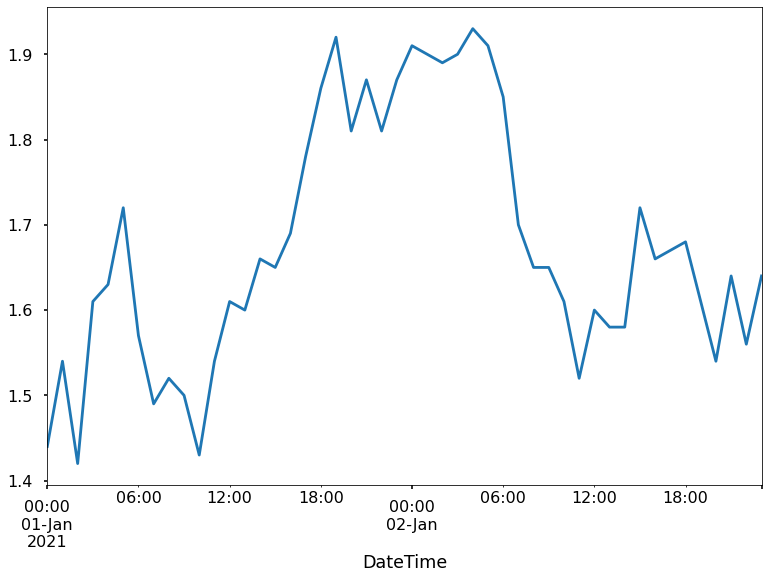

In [135]:
Obs.loc['2021-01-01':'2021-01-02'].Hsig.plot()

### Feature Engineering
We need to prepare our data for ML models to be able to accept

In [42]:
def prepstnData(df):
    df = df.copy()
      
    df['dpm_cos'] = np.cos(np.deg2rad(df['dpm_a']))
    df['dpm_sin'] = np.sin(np.deg2rad(df['dpm_a']))
    df['dm_cos'] = np.cos(np.deg2rad(df['dm_a']))
    df['dm_sin'] = np.sin(np.deg2rad(df['dm_a']))
    df['dm_sa_cos'] = np.cos(np.deg2rad(df['dm_sa_a']))
    df['dm_sa_sin'] = np.sin(np.deg2rad(df['dm_sa_a']))
    df['dm_sw_cos'] = np.cos(np.deg2rad(df['dm_sw_a']))
    df['dm_sw_sin'] = np.sin(np.deg2rad(df['dm_sw_a']))
    
    df['dpm_cos_b'] = np.cos(np.deg2rad(df['dpm_b']))
    df['dpm_sin_b'] = np.sin(np.deg2rad(df['dpm_b']))
    df['dm_cos_b'] = np.cos(np.deg2rad(df['dm_b']))
    df['dm_sin_b'] = np.sin(np.deg2rad(df['dm_b']))
    df['dm_sa_cos_b'] = np.cos(np.deg2rad(df['dm_sa_b']))
    df['dm_sa_sin_b'] = np.sin(np.deg2rad(df['dm_sa_b']))
    df['dm_sw_cos_b'] = np.cos(np.deg2rad(df['dm_sw_b']))
    df['dm_sw_sin_b'] = np.sin(np.deg2rad(df['dm_sw_b']))
    
    df['dpm_cos_c'] = np.cos(np.deg2rad(df['dpm_c']))
    df['dpm_sin_c'] = np.sin(np.deg2rad(df['dpm_c']))
    df['dm_cos_c'] = np.cos(np.deg2rad(df['dm_c']))
    df['dm_sin_c'] = np.sin(np.deg2rad(df['dm_c']))
    df['dm_sa_cos_c'] = np.cos(np.deg2rad(df['dm_sa_c']))
    df['dm_sa_sin_c'] = np.sin(np.deg2rad(df['dm_sa_c']))
    df['dm_sw_cos_c'] = np.cos(np.deg2rad(df['dm_sw_c']))
    df['dm_sw_sin_c'] = np.sin(np.deg2rad(df['dm_sw_c']))
    
    'hs','tm02','tp','dpm','dm','hs_sa','tm02_sa','dm_sa','hs_sw','tm02_sw','dm_sw'

    df = df[['hs_a','tp_a','tm02_a','dpm_cos', 'dpm_sin', 'dm_cos', 'dm_sin', 
             'hs_sa_a','tm02_sa_a','dm_sa_cos','dm_sa_sin',
             'hs_sw_a','tm02_sw_a', 'dm_sw_cos','dm_sw_sin',
             'hs_b','hs_sa_b','hs_sw_b','dm_sin_b','dm_sa_sin_b','dm_sw_sin_b',
             'hs_c','hs_sa_c','hs_sw_c','dm_sin_c','dm_sa_sin_c','dm_sw_sin_c',]].copy()
    
    return df

In [43]:
data12_prep = prepstnData(data12)
data12_prep.head(2)

,hs_a,tp_a,tm02_a,dpm_cos,dpm_sin,dm_cos,dm_sin,hs_sa_a,tm02_sa_a,dm_sa_cos,...,hs_sw_b,dm_sin_b,dm_sa_sin_b,dm_sw_sin_b,hs_c,hs_sa_c,hs_sw_c,dm_sin_c,dm_sa_sin_c,dm_sw_sin_c
time_a,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1.59,7.42,5.29,0.082634,0.996580,-0.303867,0.952715,1.40,4.82,-0.331173,...,0.89,0.991053,0.983885,0.990795,1.62,1.45,0.79,0.838385,0.840472,0.959067
2021-01-01 01:00:00,1.62,7.60,5.29,0.103313,0.994649,-0.268415,0.963303,1.41,4.79,-0.315815,...,0.93,0.996680,0.989925,0.984381,1.65,1.47,0.81,0.841511,0.831663,0.973579


**Find overlapping features (model data) and labels (observations)**

In [44]:
Obs['Dir_cos'] = np.cos(np.deg2rad(Obs['Direction']))
Obs['Dir_sin'] = np.sin(np.deg2rad(Obs['Direction']))

In [45]:
Obs.head(1)

,Hsig,Hmax,Tp,Tz,Direction,Dir_cos,Dir_sin
DateTime,,,,,,,
2018-05-10 14:00:00,1.34,2.34,5.48,4.54,24.48,0.910106,0.414376


In [46]:
data = pd.merge(Obs['Hsig'], data12_prep, left_index = True, right_index = True)

In [47]:
data.columns

Index(['Hsig', 'hs_a', 'tp_a', 'tm02_a', 'dpm_cos', 'dpm_sin', 'dm_cos',
       'dm_sin', 'hs_sa_a', 'tm02_sa_a', 'dm_sa_cos', 'dm_sa_sin', 'hs_sw_a',
       'tm02_sw_a', 'dm_sw_cos', 'dm_sw_sin', 'hs_b', 'hs_sa_b', 'hs_sw_b',
       'dm_sin_b', 'dm_sa_sin_b', 'dm_sw_sin_b', 'hs_c', 'hs_sa_c', 'hs_sw_c',
       'dm_sin_c', 'dm_sa_sin_c', 'dm_sw_sin_c'],
      dtype='object')

## Method 2: Timeseries Stacker

We need to test to understand whether there is enough autocorrelation. Then consider how to account for more recent timeseries information.

In [48]:
def plot_acf_colors(ax, markercolor="red", linecolor="black", facecolor="grey", barcolor="black", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf
    from matplotlib.collections import PolyCollection, LineCollection
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if type(item) == LineCollection:
            item.set_color(barcolor)
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

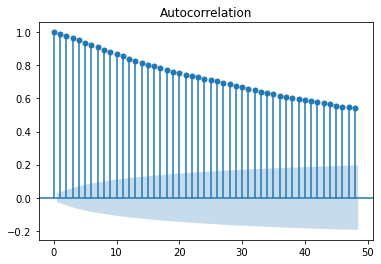

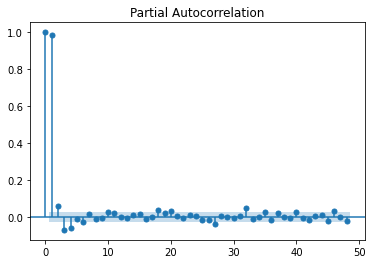

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(data['Hsig'], lags=48)
pacf = plot_pacf(data['Hsig'], lags=48)

We can observation that there is strong autocorrelation, but that diminishes, it is most strong in the first few hours (which makes sense).
Now lets look at swell from the model, is it also well correlated?

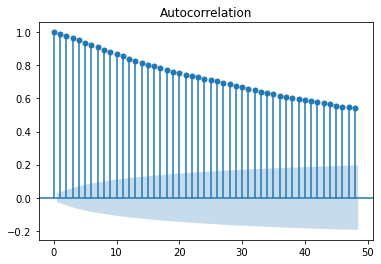

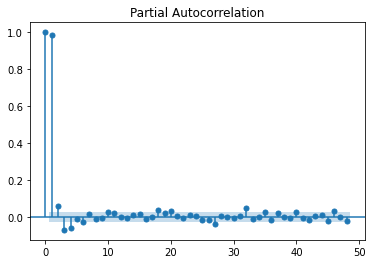

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(data['Hsig'], lags=48)
pacf = plot_pacf(data['Hsig'], lags=48)

It appears there is a good autocorrelation again for the first few timesteps, but that it drops away more quickly. This likely me means that is we are to stack the data (lag) to use previous timesteps we probably can't consider anything more than 12 hours, and certainly not more than 24 hours. 

In [51]:
#data['Hsig_lag6'] = data['Hsig'].shift(6)
#data['Hsig_lag12'] = data['Hsig'].shift(13)
data['Hs_diff_lag12'] = data['hs_a'].shift(13) - data['Hsig'].shift(13)
#data['hs_lag6'] = data['hs'].shift(6)
#data['hs_a_lag12'] = data['hs_a'].shift(13)
#data['hs_b_lag12'] = data['hs_b'].shift(13)

<AxesSubplot:>

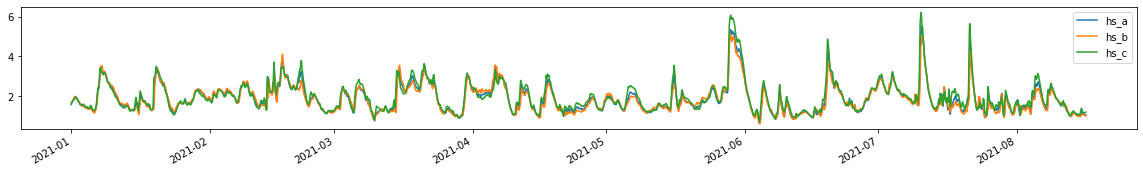

In [52]:
data[['hs_a','hs_b','hs_c']].plot(figsize = (20, 2.5))

In [53]:
data = data.dropna()

Add forecast hour

In [54]:
data['hour'] = data.index.hour

Extract independant dataset to be excluding from testing and training.

In [55]:
#ind_data = data.iloc[(int(10 * len(data.index)/100))*-1:]
#ml_data = data.iloc[:(int(10 * len(data.index)/100))*-1]

In [56]:
ind_data = data['2021-07-10 00:00':]
ml_data = data[:'2021-07-10 00:00']

## Finalising for the ML training

In [57]:
trainingColumns = ['hs_a', 'hs_sa_a','hs_sw_a',
                   'dm_sin','dm_sa_sin','dm_sw_sin',
                   'hs_b','hs_sa_b','hs_sw_b','dm_sin_b','dm_sa_sin_b','dm_sw_sin_b',
                   'hs_c','hs_sa_c','hs_sw_c','Hs_diff_lag12', 'hour']
len(trainingColumns)

17

In [58]:
#sort data down to what we need, features and labels (source and target), which in this case is univariate
labels = ml_data['Hsig'].values
features = ml_data[trainingColumns].values

In [59]:
labels.shape

(4488,)

**Scaling our data**

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [61]:
from sklearn.model_selection import TimeSeriesSplit

In [62]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [63]:
norm_f = MinMaxScaler().fit(features)
X_train = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels.reshape(-1, 1))
y_train = norm_l.transform(labels.reshape(-1, 1))

## Training

In [64]:
from sklearn.neural_network import MLPRegressor
import pickle

Guide to number of neurons

In [65]:
X_train.shape[0]/2*(X_train.shape[1]+1)

40392.0

In [66]:
6**6

46656

In [67]:
clf_mlp1 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = False,
                                             random_state = 0)

clf_mlp2 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [68]:
X_train.shape[0]//13

345

In [69]:
tscv = TimeSeriesSplit(n_splits=int(len(X_train)//13), test_size = 2)

In [70]:
for train_index, test_index in tscv.split(X_train):
    X__train_stream, X_test_stream = X_train[train_index, :], y_train[train_index, :]
    clf_mlp1.partial_fit(X__train_stream, X_test_stream.ravel())

In [71]:
#n =   #chunk row size
#xlist_df = [X_train[i:i+n] for i in range(0,X_train.shape[0],n)]
#ylist_df = [y_train[i:i+n] for i in range(0,y_train.shape[0],n)]

In [72]:
#for i in zip(xlist_df, ylist_df):
#    clf_mlp1.partial_fit(i[0], i[1].ravel())

In [73]:
y_train.shape

(4488, 1)

In [74]:
clf_mlp2.fit(X_train, y_train.ravel())

C:\Users\Leo\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(early_stopping=True, hidden_layer_sizes=(6, 6, 6, 6, 6, 6),
             random_state=0, shuffle=False)

save model for future use

In [75]:
import pickle
#pickle.dump(clf_mlp2, open("../models/twhds_mlpHs_ts.sav", 'wb'))
#pickle.dump(clf_mlp1, open("../models/twhds_mlpHs.sav", 'wb'))

In [76]:
import xgboost

In [77]:
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

In [78]:
X = pd.DataFrame(X_train)
X.columns = trainingColumns

In [79]:
X_train.shape

(4488, 17)

In [80]:
xgb = XGBRegressor( n_estimators=2000)
xgb.fit(X, y_train.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [81]:
#pickle.dump(xgb, open("../models/twhds_xgbHs.sav", 'wb'))

## Make Prediction

In [82]:
ind_data = ind_data[~ind_data.index.duplicated(keep='first')]

In [136]:
n = 12  #chunk row size
list_df = [ind_data[i:i+n] for i in range(0,ind_data.shape[0],n)]

In [137]:
def combineDirection(sin, cos):
    return np.rad2deg(np.arctan2(sin, cos))

In [138]:
import time

In [143]:
mydList = []
runtime = []
for d in list_df:
    start_time = time.time()
    hs_pred = norm_l.inverse_transform(clf_mlp1.predict(norm_f.transform(d[trainingColumns].values)).reshape(-1,1))
    runtime.append((time.time() - start_time))
    hs_pred2 = norm_l.inverse_transform(clf_mlp2.predict(norm_f.transform(d[trainingColumns].values)).reshape(-1,1))
    #start_time = time.time()
    hs_pred_xbg = norm_l.inverse_transform(xgb.predict(norm_f.transform(d[trainingColumns].values)).reshape(-1,1))
    #print((time.time() - start_time))
    runtime.append((time.time() - start_time))
    nd = d.copy()
    nd['mlp'] = hs_pred
    nd['mlp2'] = hs_pred2
    nd['xbg'] = hs_pred_xbg
    mydList.append(nd)

In [144]:
np.average(runtime)

0.0015281548625544498

In [86]:
fdata = pd.concat(mydList)

In [87]:
#hs_pred = norm_l.inverse_transform(clf_mlp1.predict(norm_f.transform(ind_data[trainingColumns].values)).reshape(-1,1))
#hs_pred2 = norm_l.inverse_transform(clf_mlp2.predict(norm_f.transform(ind_data[trainingColumns].values)).reshape(-1,1))
#hs_pred_xbg = norm_l.inverse_transform(xgb.predict(norm_f.transform(ind_data[trainingColumns].values)).reshape(-1,1))

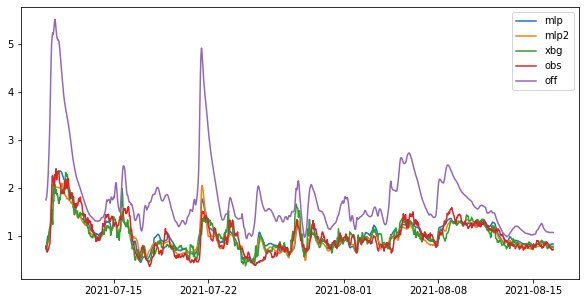

In [88]:
plt.figure(figsize = (10, 5))
plt.plot(fdata.index, fdata.mlp, label = 'mlp')
plt.plot(fdata.index, fdata.mlp2, label = 'mlp2')
plt.plot(fdata.index, fdata.xbg, label = 'xbg')
plt.plot(ind_data.index, ind_data.Hsig, label = 'obs')
plt.plot(ind_data.index, ind_data.hs_a, label = 'off')
plt.legend()

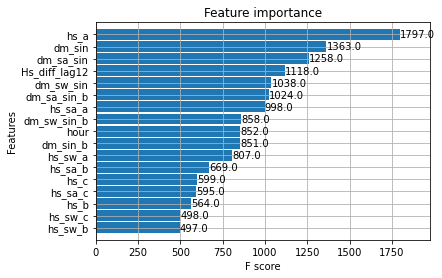

In [89]:
_ = plot_importance(xgb, height=0.9)

## Compare Performance

We also have results for a SWAN model for comparison. This model was forced by the AUSWAVE-G3 experimental model (using wave parameters to create a JONSWAP spectrum).

In [194]:
wbSWAN = pd.read_csv("../data/SWAN_wb_results.csv", parse_dates = True, index_col = 0)
wbSWAN = wbSWAN.drop_duplicates()
wbSWAN.head(2)

,% Time,Hsig,Tm02,Dir,PkDir,Watlev,Hswell,Tp_smoothed,site,site_name,lon,lat,run
Date/Time,,,,,,,,,,,,,
2021-06-24,20210624.0,1.37806,6.0729,100.572,117.5,-0.11,0.58530,9.6665,0,Brisbane WRB,153.631555,-27.487153,20210624_0000
2021-06-24,20210624.0,1.18829,5.7834,88.635,107.5,-0.11,0.49173,9.8494,1,Gold Coast WRB,153.442502,-27.963965,20210624_0000


In [195]:
modgrps = wbSWAN.groupby('run')

In [196]:
allruns12hr = []
for nm, group in modgrps:
    allruns12hr.append(group[group['site_name']==' Tweed Heads WRB'].iloc[:12])
wbSWAN = pd.concat(allruns12hr)

In [197]:
wbSWAN.index = wbSWAN.index - pd.Timedelta(hours=10)

In [198]:
wbSWAN =wbSWAN[ind_data.index[0]:ind_data.index[-1]]

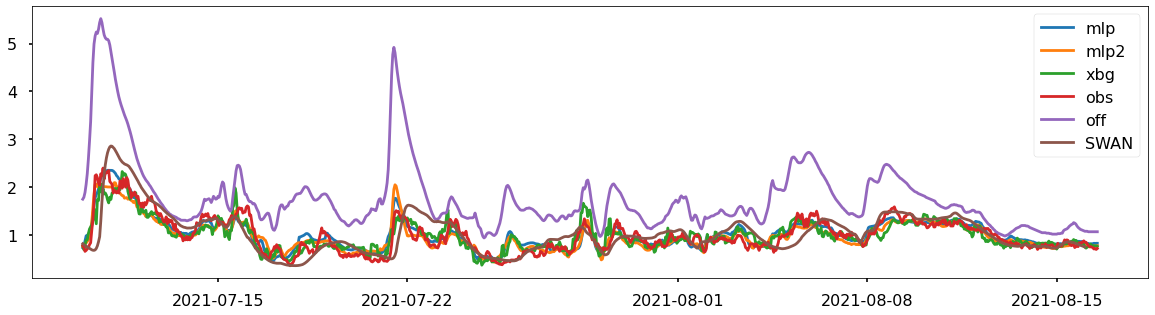

In [199]:
plt.figure(figsize =(20, 5))
plt.plot(fdata.index, fdata.mlp, label = 'mlp')
plt.plot(fdata.index, fdata.mlp2, label = 'mlp2')
plt.plot(fdata.index, fdata.xbg, label = 'xbg')
plt.plot(ind_data.index, ind_data.Hsig, label = 'obs')
plt.plot(ind_data.index, ind_data.hs_a, label = 'off')
plt.plot(wbSWAN.index, wbSWAN.Hsig, label = 'SWAN')
plt.legend()

In [200]:
import cal_stats

In [201]:
s = pd.merge(ind_data.Hsig,wbSWAN.Hsig, right_index = True, left_index = True)

In [202]:
cal_stats.all_stats(s.Hsig_y.values, s.Hsig_x.values)

{'Bias': 0.04,
 'Root Mean Squared Error': 0.26,
 'Scatter Index': 25.4,
 'Coefficient of Determination': 0.65,
 'Coefficient of Efficiency': 0.52,
 'Correlation Coefficient': 0.81,
 'Index of Agreement': 0.89}

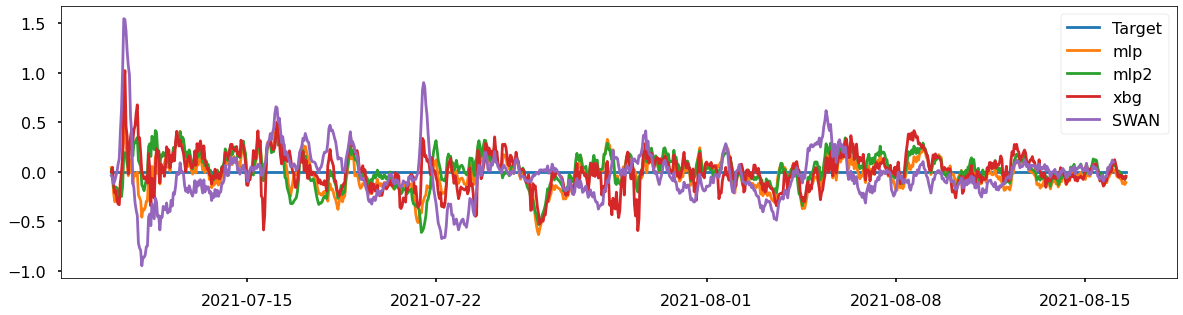

In [203]:
plt.figure(figsize =(20, 5))
plt.plot(fdata.index, ind_data.Hsig - ind_data.Hsig, label = 'Target')
plt.plot(fdata.index, ind_data.Hsig - fdata.mlp, label = 'mlp')
plt.plot(fdata.index, ind_data.Hsig - fdata.mlp2, label = 'mlp2')
plt.plot(fdata.index, ind_data.Hsig - fdata.xbg, label = 'xbg')
plt.plot(s.index, s.Hsig_x - s.Hsig_y, label = 'SWAN')
plt.legend()

In [204]:
import plotly.express as px
import plotly.graph_objects as go

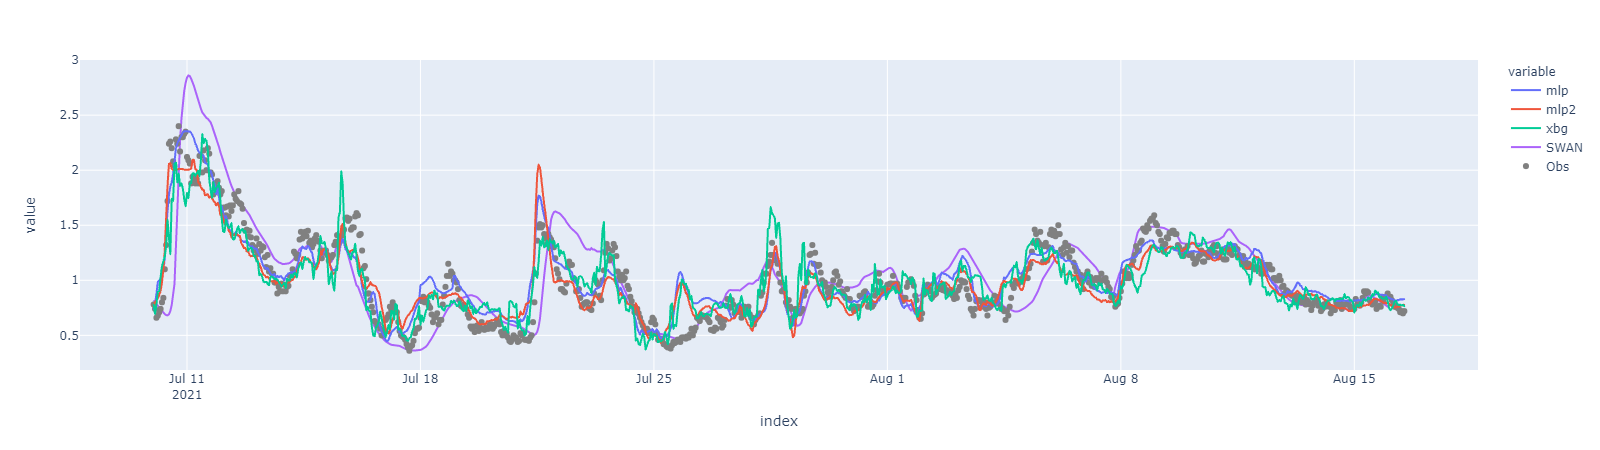

In [205]:
fig = px.line(fdata, x=fdata.index, y=['mlp','mlp2','xbg'])
fig.add_trace(go.Scatter(x = wbSWAN.index, y = wbSWAN.Hsig, name = 'SWAN'))
fig.add_trace(go.Scatter(x = fdata.index, y = fdata.Hsig, name = 'Obs', mode = "markers", marker_color='grey'))
fig.show()

In [206]:
start_d = '2021-07-10'
end_d = '2021-08-20'

###Bring in data from previous ML work

In [207]:
mlp_NN = pd.read_csv("../data/MLP_hs_obs.csv", index_col = 0, parse_dates = True)

In [208]:
#mlp_NN.index = mlp_NN.index - pd.Timedelta(hours = 10)

In [209]:
fdata['mlp_nopart'] = mlp_NN

In [210]:
cal_stats.all_stats(fdata['mlp_nopart'].loc[start_d:end_d], fdata.loc[start_d:end_d].Hsig)

{'Bias': 0.09,
 'Root Mean Squared Error': 0.26,
 'Scatter Index': 24.9,
 'Coefficient of Determination': nan,
 'Coefficient of Efficiency': nan,
 'Correlation Coefficient': nan,
 'Index of Agreement': 0.9}

In [211]:
plt.style.use('seaborn-poster')

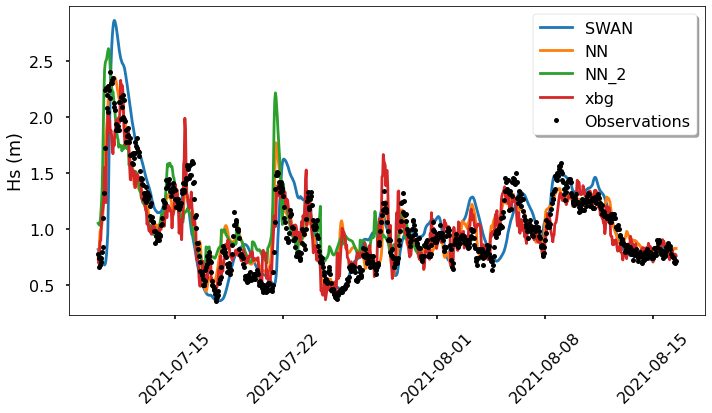

In [217]:
fig = plt.figure(figsize = (10, 5),facecolor='white')
plt.plot(wbSWAN.loc[start_d:end_d].index, wbSWAN['Hsig'].loc[start_d:end_d], label = 'SWAN')
plt.plot(fdata.loc[start_d:end_d].index, fdata['mlp'].loc[start_d:end_d], label = 'NN')
#plt.plot(fdata.loc[start_d:end_d].index, fdata['mlp2'].loc[start_d:end_d], label = 'NN2')
plt.plot(fdata.loc[start_d:end_d].index, fdata['mlp_nopart'].loc[start_d:end_d], label = 'NN_2')
plt.plot(fdata.loc[start_d:end_d].index, fdata['xbg'].loc[start_d:end_d], label = 'xbg')
plt.plot(fdata.loc[start_d:end_d].index,fdata.loc[start_d:end_d].Hsig, '.', markersize  = 10, color = 'black', label = 'Observations')
plt.ylabel('Hs (m)')
plt.legend(fancybox=True, shadow=True,)
plt.tight_layout()
plt.xticks(rotation=45)
plt.style.use('seaborn-poster')
plt.savefig('../figures/hs_timeseries.png',  bbox_inches='tight')

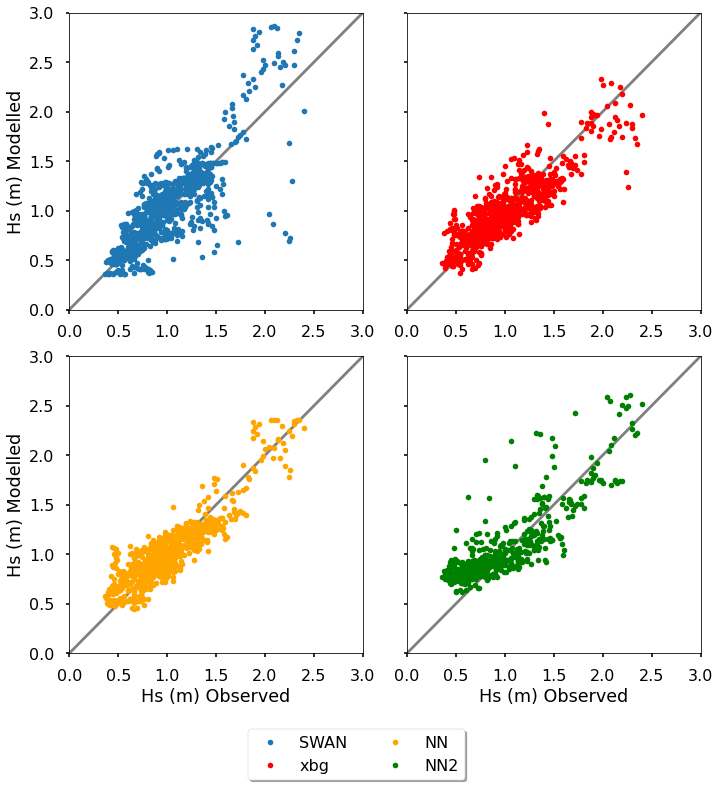

In [216]:
f, ((a0, a1),( a2, a3)) = plt.subplots(2, 2, figsize = (10,10), sharey = True, sharex = False,facecolor='white')
a0.plot([0,3], [0,3], color = 'grey')
a0.plot(fdata.loc[start_d:end_d].Hsig.iloc[:-11],wbSWAN['Hsig'].loc[start_d:end_d], '.', label = 'SWAN')
a0.set_xlim(0, 3)
a0.set_ylim(0, 3)
#a0.set_xlabel('Hs (m) Observed')
a0.set_ylabel('Hs (m) Modelled')

a2.plot([0,3], [0,3], color = 'grey')
a2.plot(fdata.loc[start_d:end_d].Hsig,fdata['mlp'].loc[start_d:end_d], '.',color = 'orange',label = 'NN')
a2.set_xlim(0, 3)
a2.set_ylim(0, 3)
a2.set_xlabel('Hs (m) Observed')
a2.set_ylabel('Hs (m) Modelled')

a3.plot([0,3], [0,3], color = 'grey')
a3.plot(fdata.loc[start_d:end_d].Hsig,fdata['mlp_nopart'].loc[start_d:end_d], '.',color = 'green',label = 'NN2')
a3.set_xlim(0, 3)
a3.set_ylim(0, 3)

a3.set_xlabel('Hs (m) Observed')

a1.plot([0,3], [0,3], color = 'grey')
a1.plot(fdata.loc[start_d:end_d].Hsig,fdata['xbg'].loc[start_d:end_d], '.',color = 'red',label = 'xbg')
a1.set_xlim(0, 3)
a1.set_ylim(0, 3)

#a1.set_xlabel('Hs (m) Observed')

lines = []
labels = []
for ax in f.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

lgd = f.legend(lines, labels,loc='lower center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=2)
#plt.suptitle('Hs Comparison')
#plt.legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.style.use("seaborn-poster")
plt.savefig('../figures/hs_scatter.png', bbox_inches='tight')

In [218]:
import numpy as np

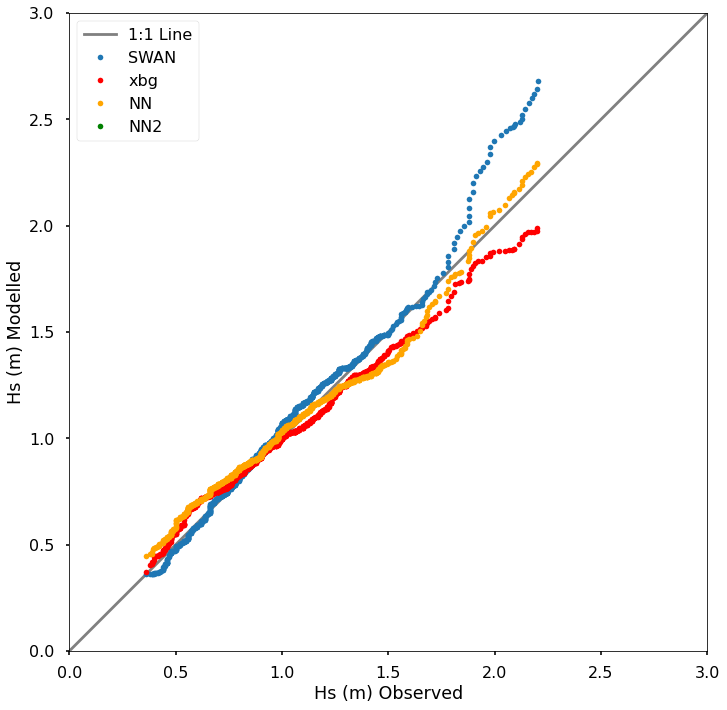

In [219]:
fig, ax = plt.subplots(figsize = (10,10),facecolor='white')
plt.plot([0,3], [0,3], color  ='Grey', label = '1:1 Line')
plt.plot(np.quantile(fdata.loc[start_d:end_d].Hsig.iloc[:-11], q = np.linspace(0, 0.99, 1000)), 
        np.quantile(wbSWAN['Hsig'].loc[start_d:end_d], q = np.linspace(0, 0.99, 1000)), '.', label = "SWAN")
plt.plot(np.quantile(fdata.loc[start_d:end_d].Hsig, q = np.linspace(0, 0.99, 1000)), 
        np.quantile(fdata['xbg'].loc[start_d:end_d], q = np.linspace(0, 0.99, 1000)), '.', label = "xbg", color = 'red')
plt.plot(np.quantile(fdata.loc[start_d:end_d].Hsig, q = np.linspace(0, 0.99, 1000)), 
        np.quantile(fdata['mlp'].loc[start_d:end_d], q = np.linspace(0, 0.99, 1000)), '.', label = "NN", color = 'orange')
plt.plot(np.quantile(fdata.loc[start_d:end_d].Hsig, q = np.linspace(0, 0.99, 1000)), 
        np.quantile(fdata['mlp_nopart'].loc[start_d:end_d], q = np.linspace(0, 0.99, 1000)), '.', label = "NN2", color = 'Green')
plt.xlim(0,3)
plt.ylim(0,3)
ax.set_box_aspect(1)
plt.xlabel('Hs (m) Observed')
plt.ylabel('Hs (m) Modelled')
plt.legend()
plt.style.use("seaborn-poster")
plt.tight_layout()
#plt.savefig("../figures/Hs_QQ_plotTH.png")

## Skill Metrics

Plotting skill metrics

In [151]:
cal_stats.

SyntaxError: invalid syntax (<ipython-input-151-6a6e01d8f032>, line 1)

**swells and lag**

In [220]:
cal_stats.all_stats(fdata.mlp, ind_data.Hsig.values)

{'Bias': 0.02,
 'Root Mean Squared Error': 0.16,
 'Scatter Index': 15.7,
 'Coefficient of Determination': 0.82,
 'Coefficient of Efficiency': 0.82,
 'Correlation Coefficient': 0.91,
 'Index of Agreement': 0.95}

In [221]:
cal_stats.all_stats(fdata.mlp2, ind_data.Hsig.values)

{'Bias': -0.02,
 'Root Mean Squared Error': 0.16,
 'Scatter Index': 16.1,
 'Coefficient of Determination': 0.82,
 'Coefficient of Efficiency': 0.81,
 'Correlation Coefficient': 0.9,
 'Index of Agreement': 0.94}

In [222]:
cal_stats.all_stats(fdata.xbg, ind_data.Hsig.values)

{'Bias': -0.01,
 'Root Mean Squared Error': 0.18,
 'Scatter Index': 18.3,
 'Coefficient of Determination': 0.76,
 'Coefficient of Efficiency': 0.76,
 'Correlation Coefficient': 0.87,
 'Index of Agreement': 0.93}

**lag, no swells**

In [185]:
cal_stats.all_stats(hs_pred.flatten(), ind_data.Hsig.values)

{'Bias': 0.0,
 'Root Mean Squared Error': 0.17,
 'Scatter Index': 12.5,
 'Coefficient of Determination': 0.85,
 'Coefficient of Efficiency': 0.82,
 'Correlation Coefficient': 0.92,
 'Index of Agreement': 0.96}

**swells, no lag**

In [159]:
cal_stats.all_stats(hs_pred.flatten(), ind_data.Hsig.values)

{'Bias': -0.03,
 'Root Mean Squared Error': 0.18,
 'Scatter Index': 13.4,
 'Coefficient of Determination': 0.8,
 'Coefficient of Efficiency': 0.79,
 'Correlation Coefficient': 0.9,
 'Index of Agreement': 0.94}

**no swells or lag**

In [134]:
cal_stats.all_stats(hs_pred.flatten(), ind_data.Hsig.values)

{'Bias': 0.08,
 'Root Mean Squared Error': 0.19,
 'Scatter Index': 12.7,
 'Coefficient of Determination': 0.83,
 'Coefficient of Efficiency': 0.78,
 'Correlation Coefficient': 0.91,
 'Index of Agreement': 0.94}

## New Offshore Data

Some completely fresh offshore data to test the ML models for 2023, three years after the current data.

In [498]:
ndata = pd.read_csv("../data/offshorePartitions_23.csv", index_col = 'time_a', parse_dates = True)

In [499]:
ndata = ndata.sort_index()
ndata = ndata[~ndata.index.duplicated(keep='first')]
ndata = ndata[['hs_a','tm02_a','tp_a','dpm_a','dm_a','hs_sa_a','tm02_sa_a','dm_sa_a','hs_sw_a','tm02_sw_a','dm_sw_a',
                'hs_b','tm02_b','tp_b','dpm_b','dm_b','hs_sa_b','tm02_sa_b','dm_sa_b','hs_sw_b','tm02_sw_b','dm_sw_b', 
                'hs_c','tm02_c','tp_c','dpm_c','dm_c','hs_sa_c','tm02_sa_c','dm_sa_c','hs_sw_c','tm02_sw_c','dm_sw_c']].round(2)
ndata = prepstnData(ndata)
ndata.head(2)

,hs_a,tp_a,tm02_a,dpm_cos,dpm_sin,dm_cos,dm_sin,hs_sa_a,tm02_sa_a,dm_sa_cos,...,hs_sw_b,dm_sin_b,dm_sa_sin_b,dm_sw_sin_b,hs_c,hs_sa_c,hs_sw_c,dm_sin_c,dm_sa_sin_c,dm_sw_sin_c
time_a,,,,,,,,,,,,,,,,,,,,,
2023-02-12 00:00:00,2.07,12.02,7.54,-0.103487,0.994631,-0.132948,0.991123,0.99,4.44,-0.265724,...,1.91,0.997515,0.964925,0.998630,2.12,0.98,1.91,0.974409,0.932891,0.977966
2023-02-12 01:00:00,2.10,12.09,7.58,-0.116844,0.993150,-0.135716,0.990748,0.98,4.38,-0.235651,...,1.94,0.997478,0.978617,0.997983,2.12,0.96,1.93,0.973179,0.938734,0.976069


In [500]:
import requests
def get_waves():
    url = "https://data.qld.gov.au/api/3/action/datastore_search?resource_id=2bbef99e-9974-49b9-a316-57402b00609c&limit=10000"
    f = requests.get(url).json()
    df = pd.DataFrame(f['result']['records'])
    df.index = pd.to_datetime(df['DateTime'])
    df.columns = df.columns.str.replace(' ', '')
    df = df[['DateTime', '_id', 'Site', 'SiteNumber', 'Seconds', 'Latitude',
      'Longitude', 'Hsig', 'Hmax', 'Tp', 'Tz', 'SST', 'Direction',
      'CurrentSpeed', 'CurrentDirection']]
    return df

In [501]:
nObs = get_waves()

In [502]:
nObs = nObs[nObs['Site'] == 'Tweed Heads Mk4']
nObs.index = nObs.index - pd.Timedelta(hours = 10)
nObs = nObs.resample('H').mean()
nObs = nObs.dropna()
nObs = nObs.round(2)

In [503]:
ndata = pd.merge(nObs['Hsig'], ndata, left_index = True, right_index = True)

In [504]:
ndata['Hs_diff_lag12'] = ndata['hs_a'].shift(13) - ndata['Hsig'].shift(13)
ndata['hour'] = ndata.index.hour
ndata = ndata.dropna()

In [505]:
features = norm_f.transform(ndata[trainingColumns].values)

In [506]:
testdf = ndata[['Hsig','hs_a']].copy()

In [507]:

hs_pred = norm_l.inverse_transform(clf_mlp1.predict(norm_f.transform(ndata[trainingColumns].values)).reshape(-1,1))
hs_pred2 = norm_l.inverse_transform(clf_mlp2.predict(norm_f.transform(ndata[trainingColumns].values)).reshape(-1,1))
hs_pred_xbg = norm_l.inverse_transform(xgb.predict(norm_f.transform(ndata[trainingColumns].values)).reshape(-1,1))
testdf['mlp'] = hs_pred
testdf['mlp2'] = hs_pred2
testdf['xbg'] = hs_pred_xbg

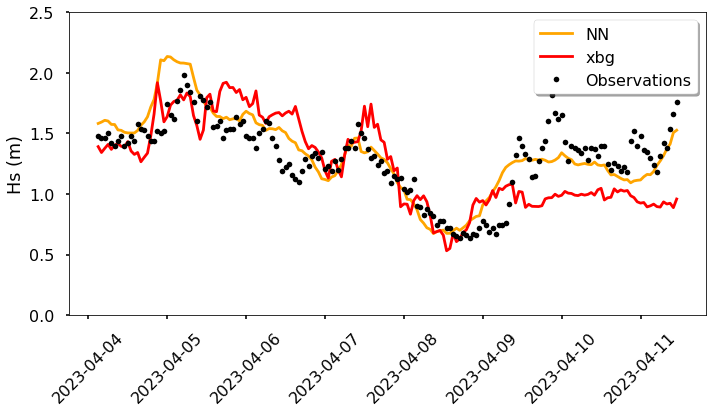

In [530]:
fig = plt.figure(figsize = (10, 5),facecolor='white')
plt.plot(testdf.index, testdf.mlp2, color = 'orange', label = 'NN')
plt.plot(testdf.index, testdf.xbg, color = 'red', label = 'xbg')
plt.plot(testdf.index, testdf.Hsig, '.', color = 'black', label = 'Observations')
plt.ylabel('Hs (m)')
plt.ylim(0, 2.5)
plt.legend(fancybox=True, shadow=True,)
plt.tight_layout()
plt.xticks(rotation=45)
plt.style.use('seaborn-poster')

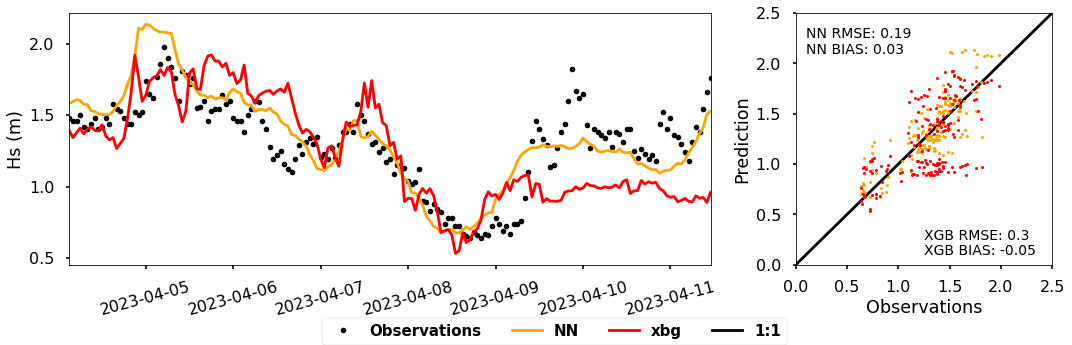

In [559]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 2]}, figsize = (15,5))
a0.plot(testdf.index, testdf.Hsig, '.', color = 'black', label = 'Observations')
a0.plot(testdf.index, testdf.mlp2, color = 'orange', label = 'NN')
a0.plot(testdf.index, testdf.xbg, color = 'red', label = 'xbg')
a0.set_ylabel('Hs (m)')
a0.set_xlim(testdf.index[0],testdf.index[-1])

a1.plot([0,2.5], [0,2.5], '-', label  = '1:1', color = 'Black')
a1.plot(testdf.Hsig, testdf.mlp2, '.', markersize = 6, color = 'orange')
a1.plot(testdf.Hsig, testdf.xbg, '.',  markersize = 6, color = 'red')
a1.text(0.1, 2.1, "NN BIAS: " +str(cal_stats.bias(testdf.mlp2, testdf.Hsig)), size = 14)
a1.text(0.1, 2.25, "NN RMSE: "+str(cal_stats.RMSE(testdf.mlp2, testdf.Hsig)), size = 14)
a1.text(1.25, 0.1, "XGB BIAS: " +str(cal_stats.bias(testdf.xbg, testdf.Hsig)), size = 14)
a1.text(1.25, 0.25, "XGB RMSE: "+str(cal_stats.RMSE(testdf.xbg, testdf.Hsig)), size = 14)
a1.set_xlabel('Observations')
a1.set_ylabel('Prediction')
a1.set_xlim(0,2.5)
a1.set_ylim(0,2.5)

f.tight_layout(rect=[0, 0.03, 1, 0.95])
legend_properties = {'weight':'bold', 'size':15}
for tick in a0.get_xticklabels():
    tick.set_rotation(15)
f.legend(loc = (0.3, 0.001), ncol=6,prop=legend_properties)
#plt.savefig('./plot_for_paper/Hs_Timeseries.png',dpi = 500)

In [535]:
cal_stats.all_stats(testdf.mlp2, testdf.Hsig.values)

{'Bias': 0.03,
 'Root Mean Squared Error': 0.19,
 'Scatter Index': 14.5,
 'Coefficient of Determination': 0.69,
 'Coefficient of Efficiency': 0.61,
 'Correlation Coefficient': 0.83,
 'Index of Agreement': 0.91}